In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
from pyedflib import highlevel
import yasa
import tqdm
import glob
import ghibtools as gt
import mne
from params import *

## PARAMS

In [3]:
input_file = glob.glob(f'../data/{patient}/*.edf')[0]

In [4]:
save_presentation = False

In [5]:
save_da = False

## TOOLS

In [6]:
def eeg_mono_to_bipol(da, dérivations, bipol_eog = True):
    da_bipol = []
    for bipol in dérivations : 
        pole1, pole2 = bipol.split('-')[0] , bipol.split('-')[1]
        if pole1 in ['EOGDt','EOGG']:
            chan1 = pole1
        
            chan2 = f'EEG {pole2}'
        else:
            chan1 = f'EEG {pole1}'
            chan2 = f'EEG {pole2}'
        sig1 = da.loc[chan1,:]
        sig2 = da.loc[chan2,:]

        bipol_sig = sig1 - sig2
        da_bipol.append(bipol_sig)
    da_bipolaire = xr.concat(da_bipol, dim = 'chan')
    da_bipolaire = da_bipolaire.assign_coords({'chan':dérivations})
    return da_bipolaire

In [7]:
def to_notch_da(da, fs):
    chans = list(da.coords['chan'].values)
    da_notched = da.copy()
    for channel in chans:
        sig = da.sel(chan = channel).values
        sig_notched = gt.notch(sig, fs=fs)
        if channel == 'ECG':
            sig_notched = -sig_notched
        da_notched.loc[channel, :] = sig_notched
    return da_notched

In [8]:
def da_to_mne_object(da, srate):
    ch_names = list(da.coords['chan'].values)
    sfreq = srate
    info = mne.create_info(ch_names, sfreq, ch_types='misc', verbose=None)
    raw = mne.io.RawArray(data = da.values, info=info, first_samp=0, copy='auto', verbose=None)
    return raw

## LOAD RAW

In [9]:
signals, signal_headers, header = highlevel.read_edf(input_file)

In [10]:
srate = signal_headers[0]['sample_rate']
chans = [chan_dict['label'] for chan_dict in signal_headers]
eeg_chans = [ chan for chan in chans if 'EEG' in chan]
eeg_chans_clean = [ chan.split(' ')[1] for chan in chans if 'EEG' in chan]
eog_chans = [ chan for chan in chans if 'EOG' in chan] 
physio_chans = [ chan for chan in chans if not 'EEG' in chan] 
unit = signal_headers[0]['dimension']
time = np.arange(0 , signals.shape[1] / srate , 1 / srate)
dérivations = ['Fp2-C4' , 'C4-T4', 'T4-O2' , 'Fz-Cz' , 'Cz-Pz' , 'Fp1-C3', 'C3-T3', 'T3-O1', 'EOGDt-A1', 'EOGG-A2']
print(f'Srate : {srate}')
print(f'Total duration : {int(time[-1])} seconds')
print(f'Nb of eeg electrodes : {len(eeg_chans)}')
print(f'Nb physios electrodes : {len(physio_chans)}')

Srate : 256.0
Total duration : 31779 seconds
Nb of eeg electrodes : 13
Nb physios electrodes : 20


## PUT RAW IN DA

In [11]:
da = xr.DataArray(data = signals, dims = ['chan','time'] , coords = {'chan':chans , 'time':time})

## DISPLAY MONOPOLAR

* raw signals

<Figure size 432x288 with 0 Axes>

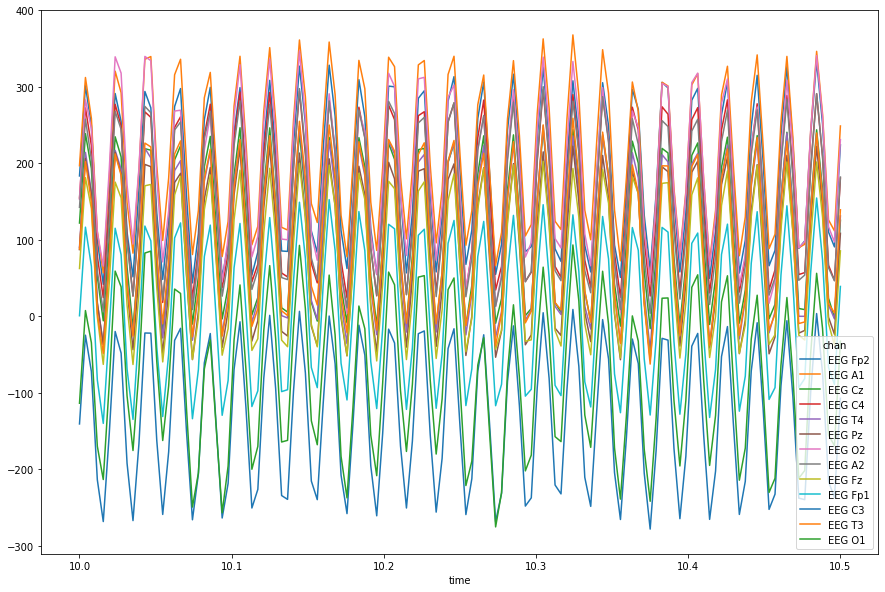

In [12]:
plt.figure()
da.loc[eeg_chans, 10:10.5].plot.line(x='time', hue = 'chan', size = 10)
if save_presentation:
    plt.savefig(f'../presentation/raw_signals_{patient}')
plt.show()

* psd of raw signals

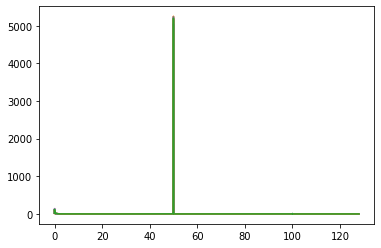

In [13]:
plt.figure()
for chan in eeg_chans :
    f, Pxx = gt.spectre(da.loc[chan,:].values, srate=srate, wsize = 50)
    plt.plot(f, Pxx)
if save_presentation:
    plt.savefig(f'../presentation/psd_raw_mono_{patient}')
plt.show()

## MONO TO BIPOLAR 

* signals

In [14]:
da_bipol = eeg_mono_to_bipol(da, dérivations = dérivations)

<Figure size 432x288 with 0 Axes>

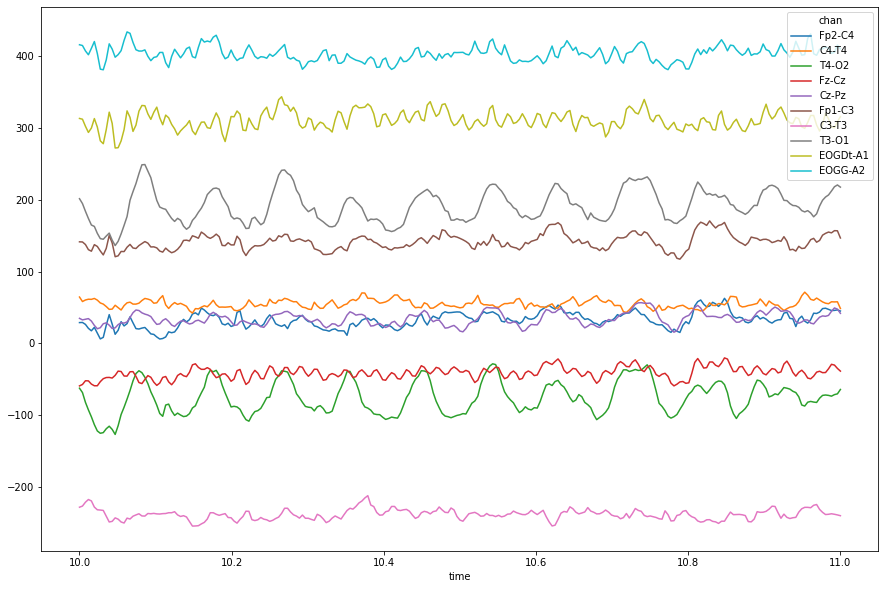

In [15]:
plt.figure()
da_bipol.loc[:,10:11].plot.line(x='time', hue = 'chan', size = 10)
if save_presentation:
    plt.savefig(f'../presentation/raw_bipol_signals_{patient}')
plt.show()

Text(0.5, 0, 'Time [s]')

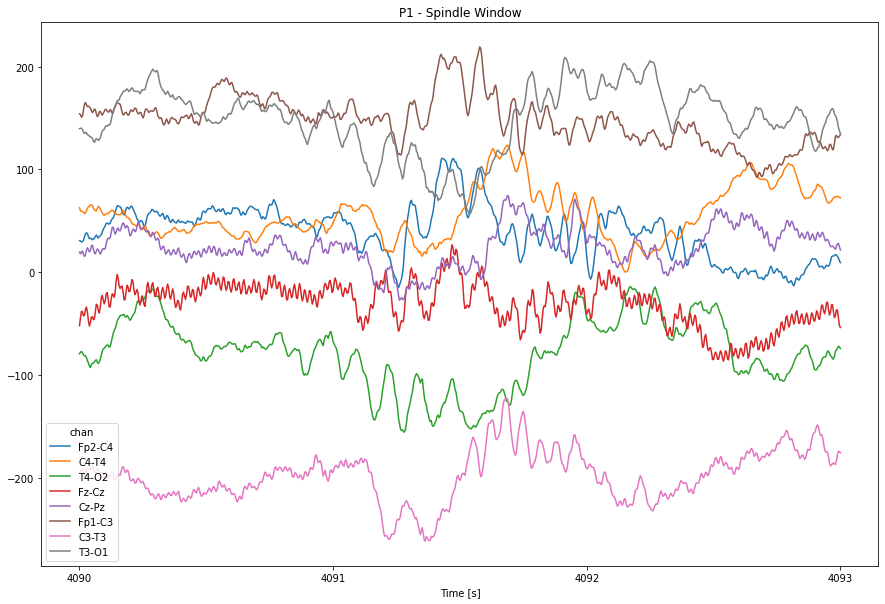

In [91]:
da_bipol.loc[['Fp2-C4','C4-T4','T4-O2','Fz-Cz','Cz-Pz','Fp1-C3','C3-T3','T3-O1'],4090:4093].plot.line(x='time', hue = 'chan', size = 10, xticks=[4090, 4091,4092,4093])
plt.title(f'{patient} - Spindle Window')
plt.xlabel('Time [s]')
# plt.savefig('../presentation_4/spindle_window_P1')

* psd

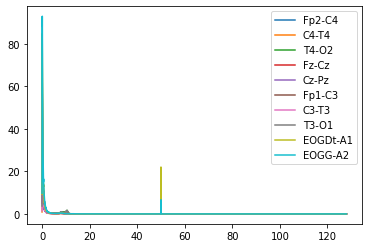

In [16]:
plt.figure()
for dérivation in dérivations:
    f, Pxx = gt.spectre(da_bipol.sel(chan = dérivation).values, srate=srate, wsize = 50)
    plt.plot(f, Pxx, label = dérivation)
    plt.legend()
if save_presentation:
    plt.savefig(f'../presentation/psd_raw_bipol_{patient}')
plt.show()

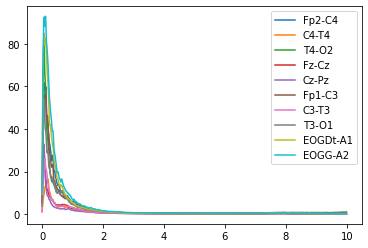

In [17]:
plt.figure()
for dérivation in dérivations:
    f, Pxx = gt.spectre(da_bipol.sel(chan = dérivation).values, srate=srate, wsize = 50)
    plt.plot(f[:1000], Pxx[:1000], label = dérivation)
    plt.legend()
plt.show()

* join bipol eeg to physios

In [18]:
da_physios = da.loc[physio_chans,:]

In [19]:
da_all = xr.concat([da_bipol , da_physios], dim = 'chan')

In [20]:
# da_all.loc[:,20:25].plot.line(x='time', row = 'chan')

In [21]:
da_all_notched = to_notch_da(da_all, fs=srate)

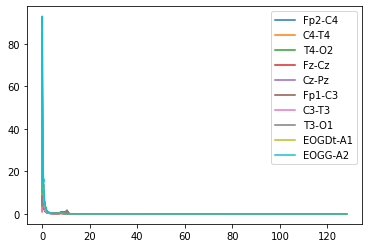

In [22]:
plt.figure()
for dérivation in dérivations:
    f, Pxx = gt.spectre(da_all_notched.sel(chan = dérivation).values, srate=srate, wsize = 50)
    plt.plot(f, Pxx, label = dérivation)
    plt.legend()
if save_presentation:
    plt.savefig(f'../presentation/psd_post_notch_{patient}')
plt.show()

In [23]:
eeg_names = [ chan for chan in dérivations if not chan in ['EOGDt-A1','EOGG-A2']]
eeg_names

['Fp2-C4', 'C4-T4', 'T4-O2', 'Fz-Cz', 'Cz-Pz', 'Fp1-C3', 'C3-T3', 'T3-O1']

## **STAGING**

* get human staging

In [24]:
def get_human_stages():
    txt_hypno_path = glob.glob(f'../data/{patient}/*AhypnoEXP.txt')[0]
    hypno = np.loadtxt(txt_hypno_path, dtype = str)
    times = hypno[:,0]
    epochs = hypno[:,2]
    
    clean_epochs = []
    double_epochs = []
    
    clean_times = []
    double_times = []
    
    for time, epoch in zip(times, epochs):
        if not time in clean_times:
            if epoch == 'REM':
                epoch = 'R'
            clean_times.append(time)
            clean_epochs.append(epoch)
        else:
            double_times.append(time)
            double_epochs.append(epoch)
            
    df_return = pd.DataFrame()
    df_return['time'] = clean_times
    df_return['label'] = clean_epochs
    return df_return.reset_index()

* get yasa staging

In [25]:
def get_yasa_stages(da_all_notched):
    raw = da_to_mne_object(da_all_notched, srate=srate)
    sls = yasa.SleepStaging(raw , eeg_name = 'C4-T4' , eog_name = 'EOGG-A2', emg_name='Menton')
    y_pred = sls.predict()
    return list(y_pred)[:-1]

In [26]:
yasa_stages = get_yasa_stages(da_all_notched)

Creating RawArray with float64 data, n_channels=30, n_times=8135680
    Range : 0 ... 8135679 =      0.000 ... 31779.996 secs
Ready.


/home/valentin.ghibaudo/.virtualenvs/py38_cluster/lib64/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


* arousal epochs

In [27]:
def get_epochs_with_arousal(patient=patient):
    # raw = mne.io.read_raw_edf(input_file)
    # annot = pd.DataFrame(raw.annotations)
    annot_path = glob.glob(f'../data/{patient}/*Annotations*')[0]
    with open(annot_path, encoding="utf8", errors='ignore') as fichier:
        contenu = fichier.read()
    rows = contenu.split('\n')
    concat = []
    for row in rows:
        concat.append(row.split('\t'))
    df_txt = pd.DataFrame(concat)
    epochs = []
    for i in range(df_txt.shape[0]):
        if 'Arousal' in str(df_txt.loc[i,6]):
            epochs.append(int(df_txt.loc[i,1]))
    return epochs

* comparison between both methods

In [28]:
def hypno_str_to_int(hypno):
    new_hypno = []
    for stage in hypno :
        if stage == 'W':
            new_hypno.append(0)
        elif stage == 'R':
            new_hypno.append(4)
        elif stage == 'N1':
            new_hypno.append(1)
        elif stage == 'N2':
            new_hypno.append(2)
        elif stage == 'N3':
            new_hypno.append(3)
    return new_hypno

In [29]:
def compare_hypno():

    human_hypno_plot = hypno_str_to_int(get_human_stages().loc[:,'label'].values)
    
    yasa_hypno = get_yasa_stages(da_all_notched)
    yasa_hypno_plot = hypno_str_to_int(yasa_hypno)
    
    plt.figure()
    yasa.plot_hypnogram(human_hypno_plot) 
    plt.title('Human')
    # plt.savefig(f'../presentation_2/staging_human')
    plt.show()
    
    plt.figure()
    yasa.plot_hypnogram(yasa_hypno_plot)
    plt.title('YASA')
    # plt.savefig(f'../presentation_2/staging__yasa')
    plt.show()

Creating RawArray with float64 data, n_channels=30, n_times=8135680
    Range : 0 ... 8135679 =      0.000 ... 31779.996 secs
Ready.


/home/valentin.ghibaudo/.virtualenvs/py38_cluster/lib64/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<Figure size 432x288 with 0 Axes>

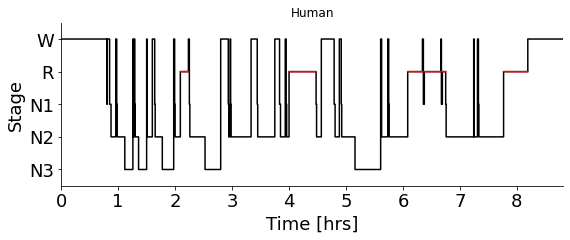

<Figure size 432x288 with 0 Axes>

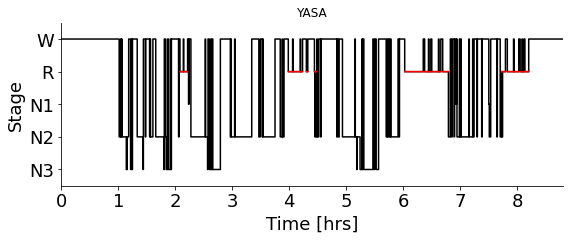

In [30]:
compare_hypno()

In [31]:
def compare_yasa_vs_human(yasa_stages=yasa_stages, human_stages=list(get_human_stages().loc[:,'label'])):
    rows = []
    mismatch_epochs = []
    mismatched_rows = []
    for i in range(len(yasa_stages)):
        yasa_epoch = yasa_stages[i]
        human_epoch = human_stages[i]
        
        if yasa_epoch == human_epoch:
            rows.append([yasa_epoch, human_epoch , 1])
        else:
            rows.append([yasa_epoch, human_epoch , 0])
            mismatch_epochs.append(i)
            mismatched_rows.append([yasa_epoch, human_epoch])
    df = pd.DataFrame(rows , columns = ['yasa','human','win'])
    df_mismatched = pd.DataFrame(mismatched_rows , columns = ['yasa','human'])
    return df, mismatch_epochs, df_mismatched
    

In [32]:
df_correspondance, mismatch_epochs, df_mismatched = compare_yasa_vs_human()

In [62]:
df_correspondance

,yasa,human,win
0,W,W,1
1,W,W,1
2,W,W,1
3,W,W,1
4,W,W,1
...,...,...,...
1053,W,W,1
1054,W,W,1
1055,W,W,1
1056,W,W,1


In [61]:
df_correspondance['win'].value_counts(normalize=True)

1    0.689981
0    0.310019
Name: win, dtype: float64

In [64]:
df_correspondance['win'].mean()

0.6899810964083176

In [58]:
df_mismatched

,yasa,human
0,W,N1
1,W,N1
2,W,N1
3,W,N1
4,W,N2
...,...,...
323,W,R
324,W,R
325,W,R
326,W,R


In [33]:
df_mismatched['human'].value_counts(normalize = True) # mismatched proportion by stage , gold-standard = human

N2    0.530488
N3    0.234756
R     0.134146
N1    0.079268
W     0.021341
Name: human, dtype: float64

In [34]:
win_stages = df_correspondance['win'].value_counts(normalize = True)
win_stages.to_excel(f'../df_analyse/win_staging_{patient}.xlsx')
win_stages

1    0.689981
0    0.310019
Name: win, dtype: float64

In [35]:
df_correspondance[df_correspondance['win'] == 1].value_counts()

yasa  human  win
W     W      1      266
N2    N2     1      242
R     R      1      154
N3    N3     1       68
dtype: int64

In [36]:
common_epochs = list(df_correspondance[df_correspondance['win'] == 1].index)

## **EPOCH CLEANING**

* sel epochs labelised commonly in human and ia and without micro arousal

In [37]:
df_labels = get_human_stages() # get human stages
epochs_arousal = get_epochs_with_arousal() # get epochs with arousal
epochs_without_arousal = [ epoch for epoch in df_labels.index if not epoch in epochs_arousal] # get epochs withhout arousal
df_labels_without_arousal = df_labels[df_labels['index'].isin(epochs_without_arousal)].loc[:,['time','label']] # mask without epochs with arousal
common_epochs_without_arousal = [ epoch for epoch in common_epochs if not epoch in epochs_arousal]
df_common_epochs_without_arousal = df_labels[df_labels['index'].isin(common_epochs_without_arousal)].loc[:,['time','label']].reset_index(drop=True).iloc[:-1,:] # not take last epoch that is cut

In [38]:
df_common_epochs_without_arousal

,time,label
0,30,W
1,60,W
2,90,W
3,120,W
4,150,W
...,...,...
660,31590,W
661,31620,W
662,31650,W
663,31680,W


In [39]:
stages_of_patient = list(df_common_epochs_without_arousal['label'].unique())
stages_of_patient

['W', 'N2', 'N3', 'R']

In [40]:
da_epoched = gt.init_da({'chan':da_all_notched.coords['chan'].values, 'epoch':df_common_epochs_without_arousal.index, 'time':np.arange(0, 30, 1 / srate)})

In [41]:
for epoch in df_common_epochs_without_arousal.index:
    start = int(df_common_epochs_without_arousal.loc[epoch, 'time'])
    stop = start + 30
    epoch_slice = da_all_notched.loc[:,start:stop].values[:,:-1]
    da_epoched.loc[:, epoch, :] = epoch_slice

In [42]:
midx = [df_common_epochs_without_arousal.index, df_common_epochs_without_arousal['label']]
midx_ready = pd.MultiIndex.from_arrays(midx, names=('epochs', 'stages'))
da_epoched_midx = da_epoched.assign_coords(coords = {'epoch':midx_ready})

In [43]:
da_epoched_midx

<xarray.DataArray (chan: 30, epoch: 665, time: 7680)>
array([[[ 3.19886293e+01,  3.05814958e+01,  3.00758873e+01, ...,
          4.76998500e+01,  4.55304535e+01,  3.83030894e+01],
        [ 3.29630567e+01,  3.54311550e+01,  4.54755706e+01, ...,
         -2.33207734e+01, -1.70988338e+01, -1.76831824e+01],
        [-1.10469774e+01, -8.69997955e+00, -1.32436293e+01, ...,
          2.43789906e+01,  1.99393719e+01,  2.01081342e+01],
        ...,
        [ 2.49667791e+01,  2.37949141e+01,  1.80767969e+01, ...,
          2.26988889e+01,  3.00008530e+01,  3.51644186e+01],
        [ 4.53305468e+01,  4.95480249e+01,  4.72687952e+01, ...,
          4.74378435e+01,  4.22493246e+01,  4.91851192e+01],
        [ 1.46064631e+01,  3.81243837e+01,  4.08824313e+01, ...,
          3.06793031e+01,  3.15877455e+01,  3.23830354e+01]],

       [[ 5.47619405e+01,  5.28580376e+01,  4.67988261e+01, ...,
          5.86189512e+01,  6.32025281e+01,  6.10016355e+01],
        [ 6.13050162e+01,  6.49400759e+01,  4.87306715e+01, ...,
          5.52349115e+01,  5.83684146e+01,  6.16451043e+01],
        [ 6.30632190e+01,  6.38463270e+01,  6.44604627e+01, ...,
          5.58861789e+01,  5.64534353e+01,  5.68153177e+01],
...
        [-3.78045111e-01, -3.75390541e-01, -3.75394544e-01, ...,
         -3.76753172e-01, -3.73250703e-01, -3.74262866e-01],
        [-3.74452661e-01, -3.75291677e-01, -3.74306592e-01, ...,
         -3.74177658e-01, -3.74226240e-01, -3.71045281e-01],
        [-3.74243881e-01, -3.73132461e-01, -3.73033275e-01, ...,
         -3.77650527e-01, -3.75649060e-01, -3.75875594e-01]],

       [[ 4.26181084e-01,  4.22115512e-01,  3.44472090e-01, ...,
          2.67370128e-01,  2.63885529e-01,  3.11367735e-01],
        [ 2.91467869e-01,  2.62059588e-01,  2.63829001e-01, ...,
          1.79498617e-01,  2.14084674e-01,  2.05697259e-01],
        [ 3.02507698e-01,  1.89458320e-01,  1.77830940e-01, ...,
          4.88007430e-01,  4.99422406e-01,  5.72674521e-01],
        ...,
        [ 3.80069201e-01,  3.71718920e-01,  3.28221165e-01, ...,
          4.12964747e-01,  3.99462995e-01,  3.52280003e-01],
        [ 3.35734957e-01,  3.90192083e-01,  4.13426875e-01, ...,
          2.83632792e-01,  2.96872871e-01,  3.02782408e-01],
        [ 2.65233787e-01,  2.79940877e-01,  3.64076817e-01, ...,
          2.95180713e-01,  3.25302740e-01,  2.91243967e-01]]])
Coordinates:
  * chan     (chan) <U8 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'CPAP' 'PRESSION' '-'
  * epoch    (epoch) MultiIndex
  - epochs   (epoch) int64 0 1 2 3 4 5 6 7 8 ... 657 658 659 660 661 662 663 664
  - stages   (epoch) object 'W' 'W' 'W' 'W' 'W' 'W' ... 'W' 'W' 'W' 'W' 'W' 'W'
  * time     (time) float64 0.0 0.003906 0.007812 0.01172 ... 29.99 29.99 30.0

## **STACKING DATA**

In [44]:
def stack_stages(da_midx, stage, srate = srate):
    da = da_midx.sel(stages = stage)
    epochs = list(da.coords['epochs'].values)
    to_concat = []
    for epoch in epochs:
        da_epoch = da.sel(epochs = epoch).reset_coords(drop=True)
        to_concat.append(da_epoch)
    da_concat = xr.concat(to_concat, dim = 'time')
    time_vector = np.arange(0,da_concat.shape[1]/srate, 1/srate)
    da_return = da_concat.assign_coords({'time':time_vector}) 
    return da_return

* stack the 30 sec epoched da multi_indexed to get one signal by chan and by stage (concat staged epochs)

In [45]:
def stack_all_stages(da_midx, stages=stages_of_patient, srate=srate):
    concat = []
    for stage in stages:
        da_stage = stack_stages(da_midx=da_midx, stage=stage, srate = srate)
        concat.append(da_stage)
    da_all_stages = xr.concat(concat, dim = 'stage')
    da_all_stages = da_all_stages.assign_coords({'stage':stages})
    return da_all_stages

In [46]:
da_all_stages = stack_all_stages(da_midx=da_epoched_midx)

* duration by stage

In [47]:
def get_duration_by_stade(da_all=da_all_stages, stages=stages_of_patient):
    for stage in stages: 
        da_sel = da_all.sel(stage=stage).dropna(dim='time')
        print( stage ,int( da_sel.coords['time'].values[-1]))

In [48]:
get_duration_by_stade()

W 6809
N2 6809
N3 1799
R 4529


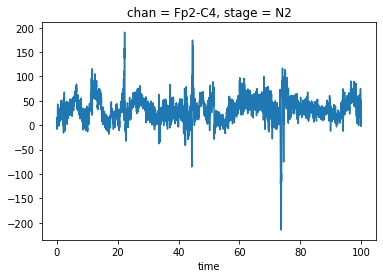

In [49]:
da_all_stages.loc['N2','Fp2-C4',0:100].plot.line(x='time', hue = 'stage')

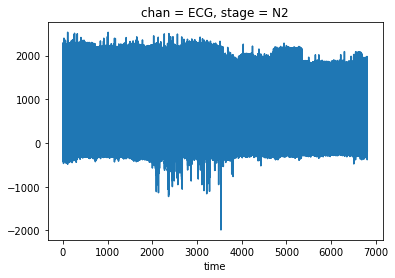

In [50]:
da_all_stages.loc['N2','ECG',:].plot()

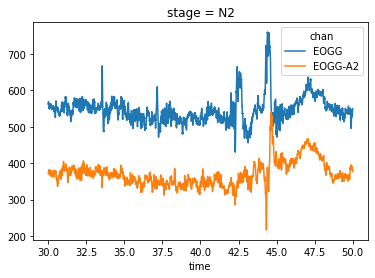

In [51]:
da_all_stages.loc['N2',['EOGG','EOGG-A2'],30:50].plot.line(x='time', hue='chan')

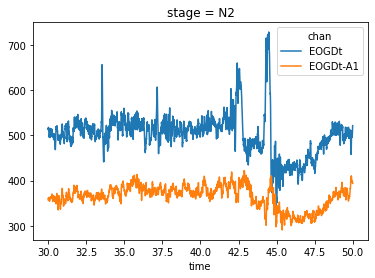

In [52]:
da_all_stages.loc['N2',['EOGDt','EOGDt-A1'],30:50].plot.line(x='time', hue='chan')

## **SAVING DATA**

In [53]:
if save_da:
    da_all_stages.sel(chan = sel_chans).to_netcdf(f'../dataarray/da_staged_{patient}.nc')

## **SUMMARIZING DATA**

In [54]:
print(patient)
print(f'Srate : {srate}')
print(f'Total duration : {int(time[-1])} seconds')
print(f'Nb of eeg electrodes : {len(eeg_chans)}')
print(f'Nb physios electrodes : {len(physio_chans)}')
print('Patient stages :', stages_of_patient)
print('Duration by stage :')
get_duration_by_stade()
print('Mismatch ia vs human by stage :')
df_mismatched['human'].value_counts(normalize = True) # mismatched proportion by stage , gold-standard = human

P1
Srate : 256.0
Total duration : 31779 seconds
Nb of eeg electrodes : 13
Nb physios electrodes : 20
Patient stages : ['W', 'N2', 'N3', 'R']
Duration by stage :
W 6809
N2 6809
N3 1799
R 4529
Mismatch ia vs human by stage :


N2    0.530488
N3    0.234756
R     0.134146
N1    0.079268
W     0.021341
Name: human, dtype: float64